# Earnings

## Setup

In [1]:
from matplotlib.colors import ListedColormap 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from lib import formatting as sd_formatting
import pyodbc 
import toml
import config_logging
import logging
import urllib.request
import pandas as pd
import colorcet as cc

log = logging.getLogger(__name__)
external_ip = urllib.request.urlopen('https://ident.me').read().decode('utf8')

properties = toml.load("./.streamlit/secrets.toml")

database_props = properties[properties["database"]["flavour"]] 


2022-08-26 17:36:40,115 [INFO] numexpr.utils: NumExpr defaulting to 4 threads.


In [2]:
## Reload

### Set up
%load_ext autoreload

%autoreload 3
from data.daos import dao_facade_local as dao_fac
from lib import db_tools as db_tools
from lib import masters_data_analytics_lib as mlib
from lib import stats as stats

db_conn = None
db_conn = db_tools.get_db_conn(database_props)


2022-08-26 17:36:42,612 [DEBUG] matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-08-26 17:36:42,617 [DEBUG] matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-08-26 17:36:43,015 [INFO] lib.db_tools: DATABASE CONNECTIVITY


### Country Average Earnings 2010 - 2021 as DF, Move to Database

In [3]:
# # index = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
# data = [[2010, 25370], [2011, 25896], [2012, 26312], [2013, 26884], [2014, 26936], [2015, 27404], [2016, 28028], \
#         [2017, 28600], [2018, 29536], [2019, 30420], [2020,30472], [2021, 31772]]

# average_country_earnings_df = pd.DataFrame(data=data, columns=["YEAR", "MEAN_INCOME_GBP_COUNTRY"])

# # average_country_earnings_df.info()

## Build the Data

### Search Critera & DAO Access to get all required data

In [31]:
year_from = 2010
year_to   = 2021
city      = "London"
borough   = "Islington"
borough   = "Barking and Dagenham"
borough   = "City of London"       # Highest
borough   = "Richmond upon Thames" # Middle
# borough   = "Sutton"               # Lowest

borough   = "Kingston upon Thames" # Some Estimated
ward_name = "St Mark's"

borough   = "Croydon" # Some Estimated
ward_name = ""

# borough   = "Lewisham"
# ward_name = "Bellingham"




# What do we have? We are only using the max for now
earnings_min_max_year_df = dao_fac.earnings_min_max_year(db_conn)

log.debug(earnings_min_max_year_df)

earnings_year_from = year_from
earnings_year_to   = year_to

earnings_year_min = earnings_min_max_year_df["MIN_YEAR"].values[0]
earnings_year_max = earnings_min_max_year_df["MAX_YEAR"].values[0]

earnings_year_from_orig = earnings_year_from
earnings_year_to_orig = earnings_year_to

if earnings_year_from < int(earnings_year_min):
    earnings_year_from = int(earnings_year_min)
elif earnings_year_from > int(earnings_year_max):
    earnings_year_from = int(earnings_year_max)

if earnings_year_to > int(earnings_year_max):
    earnings_year_to = int(earnings_year_max)
elif earnings_year_to < int(earnings_year_min):
    earnings_year_to = int(earnings_year_min)

log.debug(f"earnings orig_year_to    :{earnings_year_to_orig}")
log.debug(f"earnings search_year_to  :{earnings_year_to}")

search_term = {"year_from":earnings_year_from,
               "year_to"  :earnings_year_to,
               "borough"  :borough,
               "ward_name":ward_name}


## Get the UK Average Earnings
average_country_earnings_df = dao_fac.uk_earnings_year(db_conn, search_term)

## DATAFRAME
borough_earnings_ranking_by_year_df = dao_fac.earnings_ranked_by_borough_years(db_conn, search_term)

## MIN TO MAX YEARS TO SCROLL THROUGH
unique_years = borough_earnings_ranking_by_year_df["YEAR"].unique().tolist()

log.debug(f"orig_year_from  :{earnings_year_from_orig}")
log.debug(f"orig_year_to    :{earnings_year_to_orig}")

log.debug(f"search_year_from:{earnings_year_from}")
log.debug(f"search_year_to  :{earnings_year_to}")



2022-08-26 17:43:40,137 [DEBUG] managers.sections.sd_report_section_06_Earnings:    MAX_YEAR  MIN_YEAR
0      2021      2010
2022-08-26 17:43:40,140 [DEBUG] managers.sections.sd_report_section_06_Earnings: earnings orig_year_to    :2021
2022-08-26 17:43:40,141 [DEBUG] managers.sections.sd_report_section_06_Earnings: earnings search_year_to  :2021
2022-08-26 17:43:40,143 [DEBUG] root: retrieving uk earnings year
2022-08-26 17:43:40,167 [DEBUG] root: Retrieving Crime Ranked By Borough Years
2022-08-26 17:43:40,227 [DEBUG] managers.sections.sd_report_section_06_Earnings: orig_year_from  :2010
2022-08-26 17:43:40,229 [DEBUG] managers.sections.sd_report_section_06_Earnings: orig_year_to    :2021
2022-08-26 17:43:40,230 [DEBUG] managers.sections.sd_report_section_06_Earnings: search_year_from:2010
2022-08-26 17:43:40,232 [DEBUG] managers.sections.sd_report_section_06_Earnings: search_year_to  :2021


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
average_country_earnings_df

average_country_earnings_df[average_country_earnings_df["YEAR"].astype(int) == 2010]["MEAN_INCOME_GBP_COUNTRY"].values[0]

25370.0

In [6]:
earnings_changed_search_date_dates     = f"The new date is {earnings_year_to}" if earnings_year_from == earnings_year_to else \
                                         f"The new dates are {earnings_year_from} to {earnings_year_to}"

earnings_changed_search_s              = f" was" if earnings_year_from == earnings_year_to else \
                                         f"s were"

earnings_changed_search_date_narrative = f"Your original search date{earnings_changed_search_s} changed to match the date range of the earnings data. {earnings_changed_search_date_dates}" \
                                         if ((earnings_year_from != earnings_year_from_orig) or \
                                             (earnings_year_to   != earnings_year_to_orig)) else ""

log.debug(f"\n{earnings_changed_search_date_narrative}")

2022-08-26 17:36:43,630 [DEBUG] __main__: 



### Build Data For the Plot

In [7]:
index = []
data  = []
columns = ["CITY_MAX_IN_YEAR", "CITY_MEAN_IN_YEAR", "CITY_MIN_IN_YEAR", "BOROUGH_MEAN_IN_YEAR", "ACTUAL_ESTIMATE", "COUNTRY_MEAN_IN_YEAR"]

unique_years_plot = sorted(unique_years)

for year in unique_years_plot:
    data_row = []
    city_max_in_year     = borough_earnings_ranking_by_year_df[borough_earnings_ranking_by_year_df["YEAR"] == year]["MEAN_INCOME_GBP_BOROUGH"].max()
    city_mean_in_year    = borough_earnings_ranking_by_year_df[borough_earnings_ranking_by_year_df["YEAR"] == year]["MEAN_INCOME_GBP_BOROUGH"].mean()
    city_min_in_year     = borough_earnings_ranking_by_year_df[borough_earnings_ranking_by_year_df["YEAR"] == year]["MEAN_INCOME_GBP_BOROUGH"].min()
    borough_mean_in_year = borough_earnings_ranking_by_year_df[(borough_earnings_ranking_by_year_df["YEAR"] == year) &
                                                             (borough_earnings_ranking_by_year_df["BOROUGH"] == borough)]["MEAN_INCOME_GBP_BOROUGH"].values[0]
    borough_actual_estimate_in_year = borough_earnings_ranking_by_year_df[(borough_earnings_ranking_by_year_df["YEAR"] == year) &
                                                             (borough_earnings_ranking_by_year_df["BOROUGH"] == borough)]["MEAN_INCOME_ACTUAL_ESTIMATED"].values[0]
    country_mean_in_year = average_country_earnings_df[average_country_earnings_df["YEAR"].astype(int) == int(year)]["MEAN_INCOME_GBP_COUNTRY"].values[0]
        
    max_in_year_fmt          = "£{:,.0f}".format(city_max_in_year)
    mean_in_year_fmt         = "£{:,.0f}".format(city_mean_in_year)
    min_in_year_fmt          = "£{:,.0f}".format(city_min_in_year)
    borough_mean_in_year_fmt = "£{:,.0f}".format(borough_mean_in_year)
    country_mean_in_year_fmt = "£{:,.0f}".format(country_mean_in_year)
        
    index.append(year)
    data_row.append(city_max_in_year)
    data_row.append(city_mean_in_year)
    data_row.append(city_min_in_year)
    data_row.append(borough_mean_in_year)
    data_row.append(borough_actual_estimate_in_year)
    data_row.append(country_mean_in_year)
    data.append(data_row)
    # log.debug(f"[{borough}]-{year} - borough mean:{borough_mean_in_year_fmt} - city max:{max_in_year_fmt} - city mean:{mean_in_year_fmt} - city min:{min_in_year_fmt} - country mean:{country_mean_in_year_fmt}")
    
earning_ts_df = pd.DataFrame(data=data, index=index, columns=columns)    
earning_ts_df["Year"] = earning_ts_df.index

## Estimated or Actual
earning_ts_estimated_df = None
earning_ts_estimated_df = earning_ts_df[earning_ts_df["ACTUAL_ESTIMATE"] == "e"][["BOROUGH_MEAN_IN_YEAR", "ACTUAL_ESTIMATE"]]
earning_ts_estimated_df["Year"] = earning_ts_estimated_df.index


In [8]:
earning_ts_df
# earning_ts_estimated_df

,CITY_MAX_IN_YEAR,CITY_MEAN_IN_YEAR,CITY_MIN_IN_YEAR,BOROUGH_MEAN_IN_YEAR,ACTUAL_ESTIMATE,COUNTRY_MEAN_IN_YEAR,Year
2010,82218.0,33657.575758,24279.0,26340.0,a,25370.0,2010
2011,88064.0,34290.303030,24026.0,24026.0,a,25896.0,2011
2012,83750.0,33571.303030,23876.0,23911.0,a,26312.0,2012
2013,79149.0,33350.060606,23549.0,24405.0,a,26884.0,2013
2014,78999.0,33041.272727,21760.0,25000.0,a,26936.0,2014
2015,73479.0,32966.212121,22851.0,26323.0,a,27404.0,2015
2016,75524.0,33667.454545,24414.0,28430.0,a,28028.0,2016
2017,75996.0,34476.303030,24006.0,29044.0,a,28600.0,2017
2018,84609.0,35384.636364,23480.0,27105.0,a,29536.0,2018
2019,84234.0,36360.181818,25831.0,30372.0,a,30420.0,2019


## Build the Time Series Plot

### Text Description of Plot

In [9]:
earnings_plot_desctiption_year_range = f"between {earnings_year_from} and {earnings_year_to}" if earnings_year_to != earnings_year_from else f"for {earnings_year_to}"
earnings_plot_description_narrative = f"The graph below compares the average earnings in the {city} borough of {borough} {earnings_plot_desctiption_year_range}."
log.debug(f"\n{earnings_plot_description_narrative}")

2022-08-26 17:36:44,069 [DEBUG] __main__: 
The graph below compares the average earnings in the London borough of Lewisham between 2010 and 2021.


### Earnings Time Series Plot

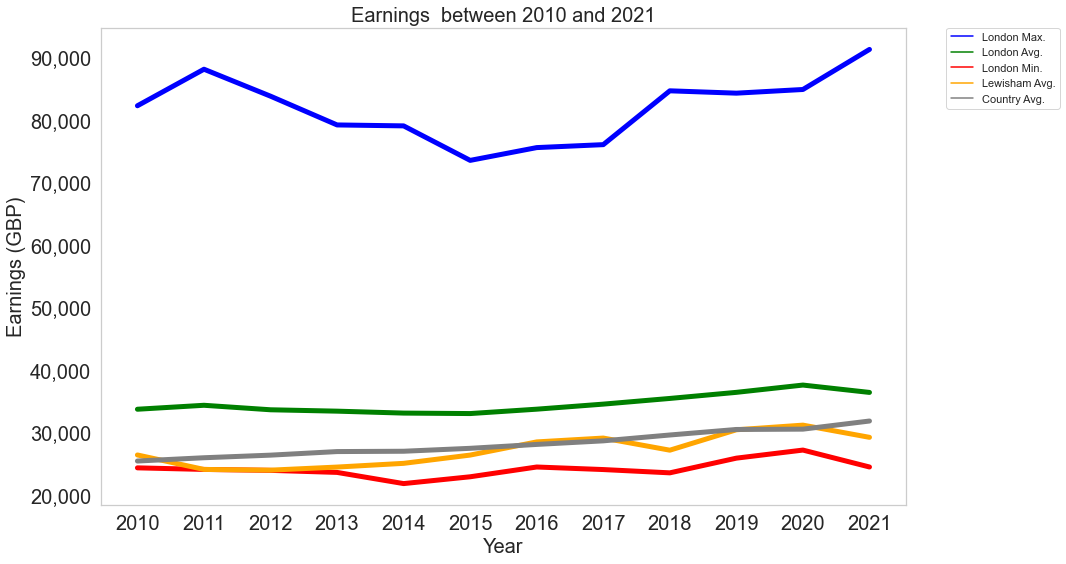

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


x_fig_size = 15
y_fig_size = 8

## Set the size
sns.set(rc={"figure.figsize":(x_fig_size, y_fig_size)})

## Set the theme
sns.set_style("whitegrid")

marker = "" if year_from != year_to else "o"

fig, ax = plt.subplots()
sns.lineplot(data=earning_ts_df, x="Year", y="CITY_MAX_IN_YEAR",     ax=ax, label=f"{city} Max.",   color='blue', marker=marker)
sns.lineplot(data=earning_ts_df, x="Year", y="CITY_MEAN_IN_YEAR",    ax=ax, label=f"{city} Avg.",    color='green', marker=marker)
sns.lineplot(data=earning_ts_df, x="Year", y="CITY_MIN_IN_YEAR",     ax=ax, label=f"{city} Min.",    color='red', marker=marker)
sns.lineplot(data=earning_ts_df, x="Year", y="BOROUGH_MEAN_IN_YEAR", ax=ax, label=f"{borough} Avg.", color='orange', marker=marker)
sns.scatterplot(data=earning_ts_estimated_df, x="Year", y="BOROUGH_MEAN_IN_YEAR", ax=ax, label=f"{borough} Avg. Estimated", color="orange", s=200)
sns.lineplot(data=earning_ts_df, x="Year", y="COUNTRY_MEAN_IN_YEAR", ax=ax, label=f"Country Avg.", color='grey', marker=marker)

plot_title = "Earnings  between {} and {}".format(earnings_year_from, earnings_year_to) if earnings_year_from != earnings_year_to else \
             "Earnings for {}".format(earnings_year_to)

ax.set_title(plot_title, fontsize=20)
ax.set_ylabel("Earnings (GBP)", fontsize=20)
ax.set_xlabel("Year", fontsize=20)

ax.legend(title="legend")
ax.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for line in ax.get_lines():
    line.set_linewidth(5)
    line.set_ms(10)

ax.grid(False)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.tight_layout()

earnings_plot = plt.gcf()

# plt.show()



### Earnings Time Series Narrative

In [11]:
## The maximum year from the data set
earnings_latest_year = average_country_earnings_df["YEAR"].max()
earnings_latest_year = year_to

## The Average earnings across all the boroughs for that year
borough_earnings_ranking_filtered_max_year_df =  borough_earnings_ranking_by_year_df[borough_earnings_ranking_by_year_df["YEAR"].astype(int) == earnings_year_to]


latest_city_max_mean_salary     = borough_earnings_ranking_filtered_max_year_df["MEAN_INCOME_GBP_BOROUGH"].max()
latest_city_mean_mean_salary    = borough_earnings_ranking_filtered_max_year_df["MEAN_INCOME_GBP_BOROUGH"].mean()
latest_borough_mean_salary      = borough_earnings_ranking_filtered_max_year_df[borough_earnings_ranking_filtered_max_year_df["BOROUGH"] == borough]["MEAN_INCOME_GBP_BOROUGH"].values[0]
latest_city_min_mean_salary     = borough_earnings_ranking_filtered_max_year_df["MEAN_INCOME_GBP_BOROUGH"].min()
latest_country_mean_mean_salary = average_country_earnings_df[average_country_earnings_df["YEAR"] == earnings_year_to]["MEAN_INCOME_GBP_COUNTRY"].values[0]


def prepend(a, b):
  ret_val = ""
  if a > b:
    ret_val = "significantly " if a/b >= 2.0 else ""
  elif a < b:
    ret_val = "significantly " if b/a >= 2.0 else ""
  return ret_val

def above_below_equal(a, b):
    ret_val = ""
    if a > b:
        if a/b <= 1.1:
            ret_val = "comparable to"
        else:
            ret_val = "above"
    elif a < b:
        if b/a <= 1.1:
            ret_val = "comparable to"
        else:
            ret_val = "below"
    else:
        ret_val = "equal to"

    return ret_val


## Format the latest for the text
### City
latest_city_max_mean_salary_fmt     = "£{:,.0f}".format(float(latest_city_max_mean_salary))
latest_city_mean_mean_salary_fmt    = "£{:,.0f}".format(float(latest_city_mean_mean_salary))
latest_borough_mean_salary_fmt      = "£{:,.0f}".format(float(latest_borough_mean_salary))
latest_city_min_mean_salary_fmt     = "£{:,.0f}".format(float(latest_city_min_mean_salary))
### Country
latest_country_mean_mean_salary_fmt = "£{:,.0f}".format(float(latest_country_mean_mean_salary))

## Preamble
part_01 = f"The {earnings_year_to} earnings in {borough} are {latest_borough_mean_salary_fmt}"

## CITY BOROUGH MEAN COMPARE TO CITY MEAN MEAN [X]
mean_explanation = f"{prepend(latest_borough_mean_salary, latest_city_mean_mean_salary)}{above_below_equal(latest_borough_mean_salary, latest_city_mean_mean_salary)}"
part_02 = f". This is {mean_explanation} the average for {city} in the same period of {latest_city_mean_mean_salary_fmt}"

# CITY BOROUGH MEAN COMPARE TO CITY MAX MEAN [X]
max_explanation = f"{prepend(latest_borough_mean_salary, latest_city_max_mean_salary)}{above_below_equal(latest_borough_mean_salary, latest_city_max_mean_salary)}"
part_03 = f" and is {max_explanation} the average maximum of {latest_city_max_mean_salary_fmt}"

# average across {city} for the same period of {latest_city_max_mean_salary_fmt}"

## CITY BOROUGH MEAN COMPARE TO CITY MIN MEAN [X]
min_explanation = f"{prepend(latest_borough_mean_salary, latest_city_min_mean_salary)}{above_below_equal(latest_borough_mean_salary, latest_city_min_mean_salary)}"
part_04 = f". It is {min_explanation} the average minimum of {latest_city_min_mean_salary_fmt}"

## CITY BOROUGH MEAN COMPARE TO COUNTRY MEAN MEAN [X] 
country_mean_explanation = f"{prepend(latest_borough_mean_salary, latest_country_mean_mean_salary)}{above_below_equal(latest_borough_mean_salary, latest_country_mean_mean_salary)}"
part_05 = f" and is {country_mean_explanation} the country average of {latest_country_mean_mean_salary_fmt}."



from scipy import stats
y = [earning_ts_df["BOROUGH_MEAN_IN_YEAR"].tolist()]
x = earning_ts_df.index.astype(int).tolist()

part_06 = ""

if len(x) >= 3:

    log.debug(y)
    log.debug(x)


    slope, intercept, r, p, std_err = stats.linregress(x, y)

    if slope == 0:
        rate = "has remained level"
    elif slope > 0:    
        if slope >= 0.1:
            rate = "has slightly increased"
        elif slope >=  0.5:
            rate = "has moderatly increased"
        else:
            rate = "has greatly increased"
    else:
        if slope <= - 0.1:
            rate = "has slightly decreased"
        elif slope <= - 0.5:
            rate = "has moderatly decreased"
        else:
            rate = "has greatly decreasd"


    part_06 = f" Over the period {earnings_year_from} to {earnings_year_to} average earnings in {borough} {rate}."

part_07 = f""

if not earning_ts_estimated_df.empty:
    estimated_list = earning_ts_estimated_df.index.to_list()
    year_prefix = "the " if len(estimated_list) == 1 else ""
    year_suffix = "" if len(estimated_list) == 1 else "s"
    estimated_prefix = "is" if len(estimated_list) == 1 else "are"
    
    part_07 = f" Please note that the earnings for {year_prefix}year{year_suffix} {sd_formatting.series_format(estimated_list)} {estimated_prefix} estimated."
    
### Put them all together  [ ]
earnings_narrative = f"{part_01}{part_02}{part_03}{part_04}{part_05}{part_06}{part_07}"

log.debug(f"\n{earnings_narrative}")


2022-08-26 17:36:45,594 [DEBUG] __main__: [[26340.0, 24026.0, 23911.0, 24405.0, 25000.0, 26323.0, 28430.0, 29044.0, 27105.0, 30372.0, 31114.0, 29162.0]]
2022-08-26 17:36:45,595 [DEBUG] __main__: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
2022-08-26 17:36:45,596 [DEBUG] __main__: 
The 2021 earnings in Lewisham are £29,162. This is below the average for London in the same period of £36,348 and is significantly below the average maximum of £91,232. It is above the average minimum of £24,416 and is comparable to the country average of £31,772. Over the period 2010 to 2021 average earnings in Lewisham has slightly increased.


In [12]:
borough_earnings_ranking_filtered_max_year_df

,YEAR,BOROUGH,RANK,MEAN_INCOME_GBP_BOROUGH,MEAN_INCOME_ACTUAL_ESTIMATED
0,2021,City of London,1,91232.0,a
1,2021,Tower Hamlets,2,58406.0,a
2,2021,Westminster,3,57129.0,a
3,2021,Islington,4,48498.0,a
4,2021,Southwark,5,43431.0,a
5,2021,Hounslow,6,41585.0,a
6,2021,Camden,7,41554.0,a
7,2021,Hammersmith and Fulham,8,39282.0,a
8,2021,Kensington and Chelsea,9,38807.0,a
9,2021,Lambeth,10,36687.0,a


## Build Bump Chart Plot

In [13]:
years_sorted = borough_earnings_ranking_by_year_df["YEAR"].sort_values().drop_duplicates()
first_year = years_sorted.iloc[0]
borough_sort_order = borough_earnings_ranking_by_year_df.loc[borough_earnings_ranking_by_year_df["YEAR"]==first_year]["BOROUGH"]
top_borough = borough_sort_order.iloc[0]
mid_borough = borough_sort_order.iloc[16]
bottom_borough = borough_sort_order.iloc[-1]

## Loop through the boroughs in the sort order of first year
all_borough_ranking_by_year = []

## BOROUGH LOOP
for _borough in borough_sort_order:

    borough_ranking_by_year_list = []

    ## Add the Borough
    borough_ranking_by_year_list.append(_borough)

    ## YEAR LOOP
    for year in years_sorted:

        borough_ranking_for_year = borough_earnings_ranking_by_year_df.loc[(borough_earnings_ranking_by_year_df["BOROUGH"]==_borough) &
                                                                           (borough_earnings_ranking_by_year_df["YEAR"]==year)]["RANK"].values[0]

        borough_ranking_by_year_list.append(borough_ranking_for_year)

    all_borough_ranking_by_year.append(borough_ranking_by_year_list)

columns = ["Borough"] + list(years_sorted)

all_borough_ranking_by_year_df = pd.DataFrame(all_borough_ranking_by_year, columns=columns).set_index("Borough")

tmb_borough_ranking_by_year_df = all_borough_ranking_by_year_df.copy()


### Earnings Time Series Bump Chart Narrative

In [14]:
earnings_bump_chart_date_range = f"over the period {earnings_year_from} to {earnings_year_to}" if earnings_year_from != earnings_year_to else f"for {earnings_year_to}"

earnings_bump_chart_narrative = f"How {borough} ranks with the other London boroughs {earnings_bump_chart_date_range} can be seen below. Ranking is top to bottom, with the top representing the highest earnings."
log.debug(f"\n{earnings_bump_chart_narrative}")

2022-08-26 17:36:46,364 [DEBUG] __main__: 
How Lewisham ranks with the other London boroughs over the period 2010 to 2021 can be seen below. Ranking is top to bottom, with the top representing the highest earnings.


### Earnings Time Series Bump Chart

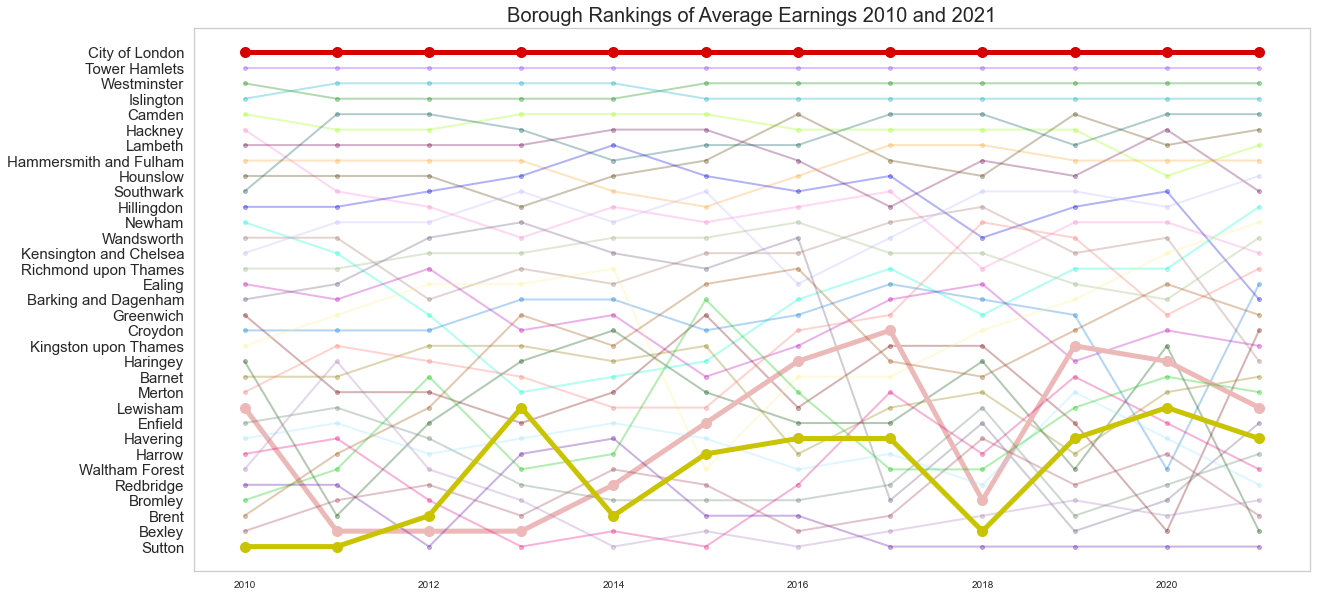

In [15]:
palette = sns.color_palette(cc.glasbey, n_colors=len(borough_sort_order))
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())
ax = all_borough_ranking_by_year_df.T.plot(figsize=(20, 10), marker="o",  ms=5, cmap=my_cmap)

ax.grid(False)
title = f"Borough Rankings of Average Earnings {earnings_year_from} and {earnings_year_to}" if earnings_year_from != earnings_year_to else \
        f"Borough Rankings of Average Earnings in {earnings_year_to}"

ax.set_title(title, fontsize=20)

plt.xticks(fontsize=10)

## Generate labels from the Borough names for the Y Axis
plt.yticks(range(1, len(borough_sort_order)+1), [borough_sort_order.iloc[i] for i in range(len(borough_sort_order))])
plt.yticks(fontsize=15)

plt.gca().invert_yaxis()
plt.gca().get_legend().remove()

for line in ax.get_lines():
    # if (line.get_label() == borough) or (line.get_label() == top_borough) or (line.get_label() == mid_borough) or (line.get_label() == bottom_borough):
    if (line.get_label() == borough) or (line.get_label() == top_borough) or (line.get_label() == bottom_borough):
        line.set_linewidth(5)
        line.set_ms(10)
    else:
        line.set_linewidth(2)
        line.set_ms(4)
        line.set_alpha(0.3)

earnings_bump_plot = plt.gcf()         
# plt.show(block=True)
    

### Build the table for year on year benchmark salaries

In [16]:
earnings_benchamark_data = []

## Loop through the years to create our data frame for benchmarking

unique_years_bench = sorted(unique_years, reverse=True)

for year in unique_years_bench:
  ## Vertical Slice  
  borough_year_data = all_borough_ranking_by_year_df[year] 
  ## Loop through each borough
  idx = 0;
  
  ## Add uear to the dataframe row
  earnings_benchmark_data_row = []
  earnings_benchmark_data_row.append(str(year))

  for earnings_borough in borough_year_data.index:
    ranking = borough_year_data[idx]     
    borough_max_min_earnings_year = earning_ts_df[earning_ts_df["Year"].astype(int) == int(year)][["CITY_MAX_IN_YEAR", "CITY_MIN_IN_YEAR"]]
    
    max_borough_earnings_for_year = borough_max_min_earnings_year["CITY_MAX_IN_YEAR"]
    max_borough_earnings_for_year_fmt = "£{:,.0f}".format(float(max_borough_earnings_for_year))
    
    min_borough_earnings_for_year = borough_max_min_earnings_year["CITY_MIN_IN_YEAR"]
    min_borough_earnings_for_year_fmt = "£{:,.0f}".format(float(min_borough_earnings_for_year))

    # log.debug(ranking)
    if ranking == 1:
      max_str = f"{earnings_borough} - {max_borough_earnings_for_year_fmt}"
    
    if ranking == 33:
      min_str = f"{earnings_borough} - {min_borough_earnings_for_year_fmt}"
    
    idx += 1
    
  ## Lowest borough in year
  earnings_benchmark_data_row.append(min_str)
  
  ## Our borough's 
  search_borough_avg_earnings_year = earning_ts_df[earning_ts_df["Year"] == year]["BOROUGH_MEAN_IN_YEAR"].values[0]
  search_borough_avg_earnings_year_fmt = "£{:,.0f}".format(float(search_borough_avg_earnings_year))
  earnings_benchmark_data_row.append(search_borough_avg_earnings_year_fmt)

  ## Highest borough in year
  earnings_benchmark_data_row.append(max_str)
  
  earnings_benchamark_data.append(earnings_benchmark_data_row)
  
  earnings_benchamark_data_df = pd.DataFrame(data=earnings_benchamark_data, columns=["Year", "Borough with Lowest Avg. Earnings", f"{borough} Avg. Earnings", "Borough with Highest Avg. Earnings"])
  earnings_benchamark_data_df = earnings_benchamark_data_df.set_index("Year")
    
    
from IPython.display import HTML
styles = [
  dict(selector="tr", props=[("font-size", "120%"),
                             ("text-align", "right")])
]

earnings_benchamark_data_df_html = (earnings_benchamark_data_df.style.set_table_styles(styles))


In [17]:
earning_ts_df

,CITY_MAX_IN_YEAR,CITY_MEAN_IN_YEAR,CITY_MIN_IN_YEAR,BOROUGH_MEAN_IN_YEAR,ACTUAL_ESTIMATE,COUNTRY_MEAN_IN_YEAR,Year
2010,82218.0,33657.575758,24279.0,26340.0,a,25370.0,2010
2011,88064.0,34290.303030,24026.0,24026.0,a,25896.0,2011
2012,83750.0,33571.303030,23876.0,23911.0,a,26312.0,2012
2013,79149.0,33350.060606,23549.0,24405.0,a,26884.0,2013
2014,78999.0,33041.272727,21760.0,25000.0,a,26936.0,2014
2015,73479.0,32966.212121,22851.0,26323.0,a,27404.0,2015
2016,75524.0,33667.454545,24414.0,28430.0,a,28028.0,2016
2017,75996.0,34476.303030,24006.0,29044.0,a,28600.0,2017
2018,84609.0,35384.636364,23480.0,27105.0,a,29536.0,2018
2019,84234.0,36360.181818,25831.0,30372.0,a,30420.0,2019


In [18]:
earnings_ranking_chart_narrative = f"The table below shows the borough average earnings rankings for each year"
log.debug(f"\n{earnings_ranking_chart_narrative}")

2022-08-26 17:36:47,954 [DEBUG] __main__: 
The table below shows the borough average earnings rankings for each year


In [19]:
earnings_benchamark_data_df_html

,Borough with Lowest Avg. Earnings,Lewisham Avg. Earnings,Borough with Highest Avg. Earnings
Year,,,
2021,"Redbridge - £24,416","£29,162","City of London - £91,232"
2020,"Redbridge - £27,123","£31,114","City of London - £84,822"
2019,"Redbridge - £25,831","£30,372","City of London - £84,234"
2018,"Redbridge - £23,480","£27,105","City of London - £84,609"
2017,"Redbridge - £24,006","£29,044","City of London - £75,996"
2016,"Waltham Forest - £24,414","£28,430","City of London - £75,524"
2015,"Harrow - £22,851","£26,323","City of London - £73,479"
2014,"Waltham Forest - £21,760","£25,000","City of London - £78,999"
2013,"Harrow - £23,549","£24,405","City of London - £79,149"


# REPORT PAGE

In [20]:
print(earnings_changed_search_date_narrative) #If it isn't altered this line doesn't show
print(earnings_plot_description_narrative)


The graph below compares the average earnings in the London borough of Lewisham between 2010 and 2021.


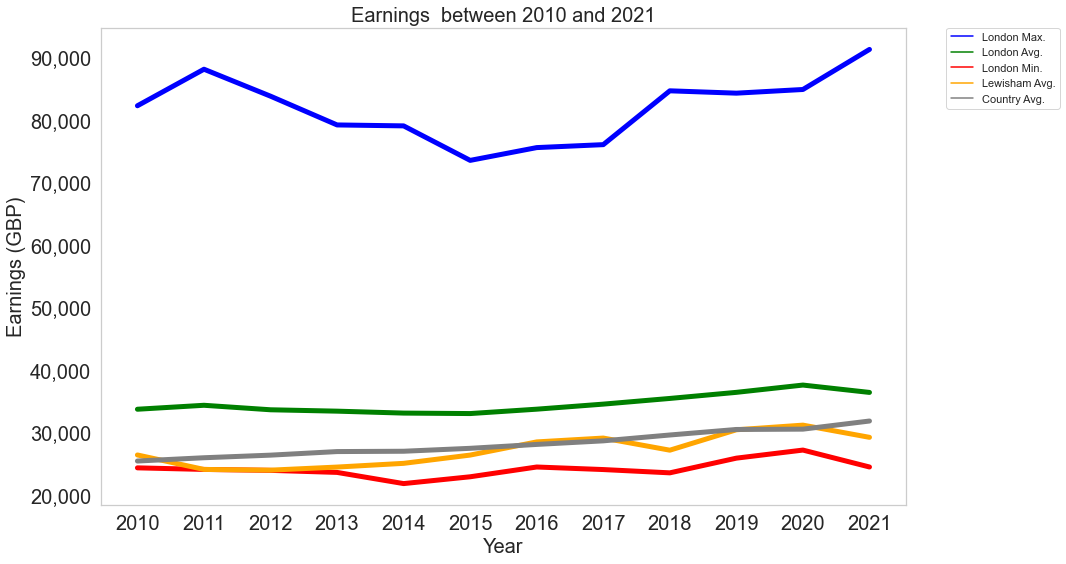

In [21]:
earnings_plot


In [22]:
print(earnings_narrative)
print("")
print(earnings_bump_chart_narrative)

The 2021 earnings in Lewisham are £29,162. This is below the average for London in the same period of £36,348 and is significantly below the average maximum of £91,232. It is above the average minimum of £24,416 and is comparable to the country average of £31,772. Over the period 2010 to 2021 average earnings in Lewisham has slightly increased.

How Lewisham ranks with the other London boroughs over the period 2010 to 2021 can be seen below. Ranking is top to bottom, with the top representing the highest earnings.


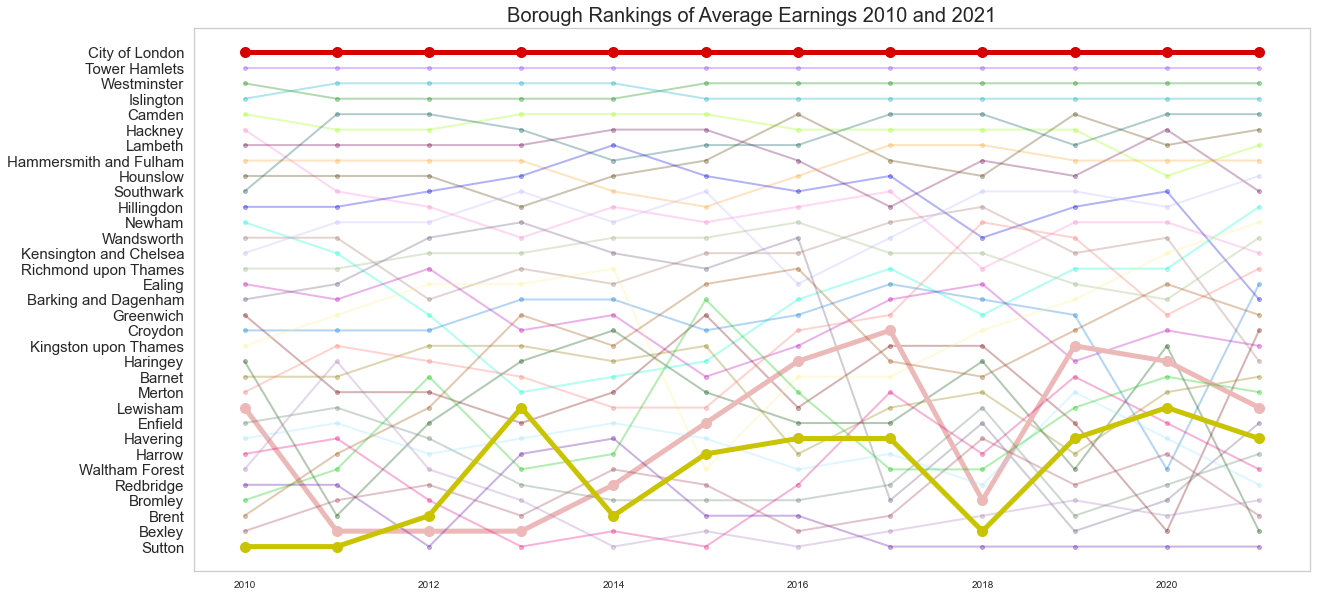

In [23]:
earnings_bump_plot

In [24]:
print(earnings_ranking_chart_narrative)

The table below shows the borough average earnings rankings for each year


In [25]:
earnings_benchamark_data_df_html

,Borough with Lowest Avg. Earnings,Lewisham Avg. Earnings,Borough with Highest Avg. Earnings
Year,,,
2021,"Redbridge - £24,416","£29,162","City of London - £91,232"
2020,"Redbridge - £27,123","£31,114","City of London - £84,822"
2019,"Redbridge - £25,831","£30,372","City of London - £84,234"
2018,"Redbridge - £23,480","£27,105","City of London - £84,609"
2017,"Redbridge - £24,006","£29,044","City of London - £75,996"
2016,"Waltham Forest - £24,414","£28,430","City of London - £75,524"
2015,"Harrow - £22,851","£26,323","City of London - £73,479"
2014,"Waltham Forest - £21,760","£25,000","City of London - £78,999"
2013,"Harrow - £23,549","£24,405","City of London - £79,149"


# REPORT GENERATION

## ARTEFACTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2022-08-26 17:43:46,881 [INFO] lib.db_tools: DATABASE CONNECTIVITY
2022-08-26 17:43:46,882 [DEBUG] managers.sections.sd_report_section_06_Earnings:    MAX_YEAR  MIN_YEAR
0      2021      2010
2022-08-26 17:43:46,885 [DEBUG] managers.sections.sd_report_section_06_Earnings: earnings orig_year_to    :2021
2022-08-26 17:43:46,886 [DEBUG] managers.sections.sd_report_section_06_Earnings: earnings search_year_to  :2021
2022-08-26 17:43:46,887 [DEBUG] root: retrieving uk earnings year
2022-08-26 17:43:46,908 [DEBUG] root: Retrieving Crime Ranked By Borough Years


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-08-26 17:43:47,936 [DEBUG] managers.sections.sd_report_section_06_Earnings: [[27713.0, 27279.0, 28166.0, 28663.0, 28408.0, 27861.0, 28940.0, 30019.0, 30431.0, 31953.0, 29132.0, 33552.0]]
2022-08-26 17:43:47,936 [DEBUG] managers.sections.sd_report_section_06_Earnings: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
2022-08-26 17:43:49,293 [DEBUG] managers.sections.sd_report_section_06_Earnings: {'earnings_narrative_01': '', 'earnings_narrative_02': 'The graph {} compares the average earnings in the London borough of Croydon between 2010 and 2021 with the London maximum, minimum and average and with the country average.', 'earnings_time_series_plot': './reports/generation/images/SECTION_TEST_06_EARNINGS_earnings_time_series_plot_London_2010_2021.png', 'earnings_narrative_03': 'The 2021 earnings in Croydon are £33,552. This is comparable to the average for London in the same period of £36,348 and is significantly below the average maximum of £91,232. It is ab

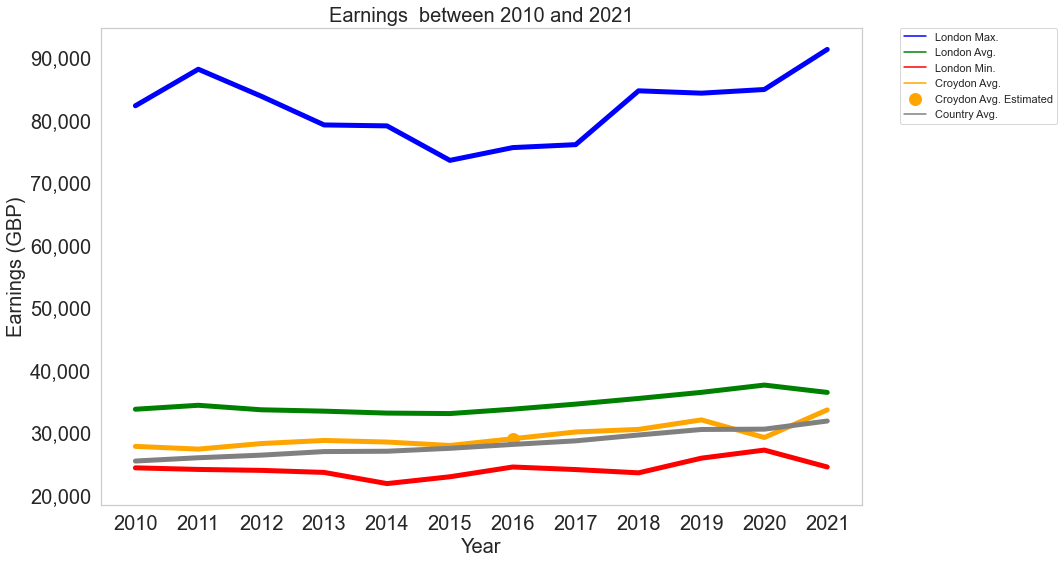

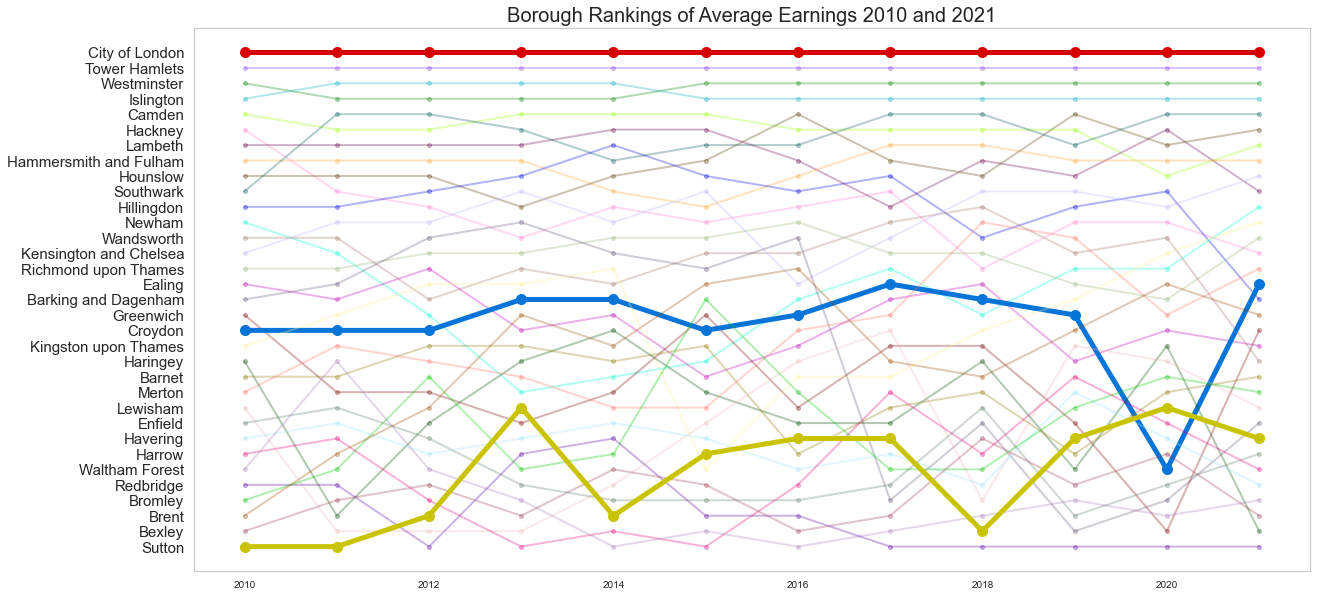

In [32]:
### Set up
%load_ext autoreload

%autoreload 3
from data.daos import dao_facade_local as dao_fac
from lib import masters_data_analytics_lib as mlib
from managers.sections import sd_report_section_06_Earnings as report_section_earnings

session_id = "SECTION_TEST_06_EARNINGS"
report_context = {}
search_term = {
    "city"      : city
  , "borough"   : borough
  , "ward_name" : ward_name
  , "year_to"   : year_to
  , "year_from" : year_from
}

report_section_earnings.generate_report_section(session_id     = session_id
                      , search_term    = search_term
                      , report_context = report_context
                      , properties     = properties 
                      , dao_fac        = dao_fac)  

log.debug(report_context)

## REPORT

In [33]:
%load_ext autoreload

%autoreload 3

from managers import sd_report_manager_new as report_man

report_context_new = {"template_processor_file_name":"./reports/processors/sd_test_generation_06_earnings.json",
                      "report_option":1} 

report_context.update(report_context_new)

log.debug("Started")
generated_report = report_man.generate_report(session_id
                                            , report_context = report_context
                                            , properties = properties)
log.debug("Finished")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2022-08-26 17:43:55,386 [DEBUG] managers.sections.sd_report_section_06_Earnings: Started
2022-08-26 17:43:55,399 [DEBUG] managers.sd_report_manager_new: text_alignment:justify
2022-08-26 17:43:55,434 [DEBUG] managers.sd_report_manager_new: alignment:left
2022-08-26 17:43:55,442 [WARNING] managers.sd_report_manager_new: Not a Command
2022-08-26 17:43:55,443 [WARNING] managers.sd_report_manager_new: Not a Command
2022-08-26 17:43:55,447 [WARNING] managers.sd_report_manager_new: Not a Command
2022-08-26 17:43:55,450 [DEBUG] managers.sd_report_manager_new: text_alignment:justify
2022-08-26 17:43:55,495 [DEBUG] managers.sd_report_manager_new: alignment:left
2022-08-26 17:43:55,505 [WARNING] managers.sd_report_manager_new: Not a Command
2022-08-26 17:43:55,507 [DEBUG] managers.sd_report_manager_new: text_alignment:justify
2022-08-26 17:43:55,591 [DEBUG] managers.sd_report_manager_new: text_alignment:justi